# Wind Power Prediction by LSTM RNN

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Preperation
### Get data from csv file

In [2]:
def get_data(csv_path):
    data = pd.read_csv(csv_path, header=None)
    npdata = data.values
    return npdata

path_power = "power_output_jz.csv"
data_power = get_data(path_power)
print("Power data shape is", data_power.shape)
# print(data_power)

path_wind = "wind_output_jz.csv"
data_wind = get_data(path_wind)
print("Wind data shape is", data_wind.shape)
# print(data_wind)

path_direc = "direc_output.csv"
data_direc = get_data(path_direc)
print("Wind direction data shape is", data_direc.shape)

Power data shape is (366, 48)
Wind data shape is (366, 48)
Wind direction data shape is (366, 48)


### Data cleaning

In [3]:
def clean_nan(data):
#     print("## NaN value found in these location:")
    nan_idx = np.argwhere(np.isnan(data))
#     print(nan_idx)
    

    # If there are some NaN values
    if len(nan_idx != 0):
        for idx in nan_idx:
#             print("Before: ", data[idx[0], idx[1]])
            assert(np.isnan(data[idx[0], idx[1]]))
            assert(~np.isnan(data[idx[0], idx[1]-1]))
            assert(~np.isnan(data[idx[0], idx[1]+1]))
            data[idx[0], idx[1]] = np.average([data[idx[0], idx[1]-1], 
                                               data[idx[0], idx[1]+1]]) 
#             print("After: ", data[idx[0], idx[1]])
    return data

data_power_clean = clean_nan(data_power)
data_wind_clean = clean_nan(data_wind)
data_direc_clean = clean_nan(data_direc)
# print("\n## After cleaning, Nan location:")
# print("Power NaN: ", np.argwhere(np.isnan(data_power_clean)))
# print("Wind NaN: ", np.argwhere(np.isnan(data_wind_clean)))
# print("Direction NaN: ", np.argwhere(np.isnan(data_direc_clean)))

### Data normalization

In [4]:
def flatten(data):
    return data.flatten()

data_power_flatten = flatten(data_power_clean)
data_wind_flatten = flatten(data_wind_clean)
data_direc_flatten = flatten(data_direc_clean)
flatten_data_size = np.shape(data_power_flatten)[0]
print(flatten_data_size)
assert np.shape(data_wind_flatten)[0] == flatten_data_size
assert np.shape(data_direc_flatten)[0] == flatten_data_size

17568


In [5]:
def normalize(data):
    assert(len(np.shape(data)) == 1), \
    "Data pass in normalize() must be flattened!"
    
    max_val = data.max()
    print('Max value =', max_val)
    data_n = data / max_val
    return data_n, max_val

data_power_normalize, power_max_val = normalize(data_power_flatten) 
data_wind_normalize, wind_max_val = normalize(data_wind_flatten)
data_direc_normalize, direc_max_val = normalize(data_direc_flatten)

# print("\ndata_power_normalize")
# print("Max:", data_power_normalize.max())
# print("Min:", data_power_normalize.min())
# print("\ndata_wind_normalize")
# print("Max:", data_wind_normalize.max())
# print("Min:", data_wind_normalize.min())
# print("\ndata_direc_normalize")
# print("Max:", data_direc_normalize.max())
# print("Min:", data_direc_normalize.min())

Max value = 1589.0
Max value = 26.47499275
Max value = 1.0


### Visualize input data

In [6]:
# # plt.hist(data_power_normalize, bins = 300, normed=True)
# # plt.show()

# _, ax = plt.subplots(figsize=(15,5))
# ax.hist(data_power_normalize, bins=200, normed=True)
# _, bx = plt.subplots(figsize=(15,5))
# bx.hist(data_wind_normalize, bins=200, normed=True)

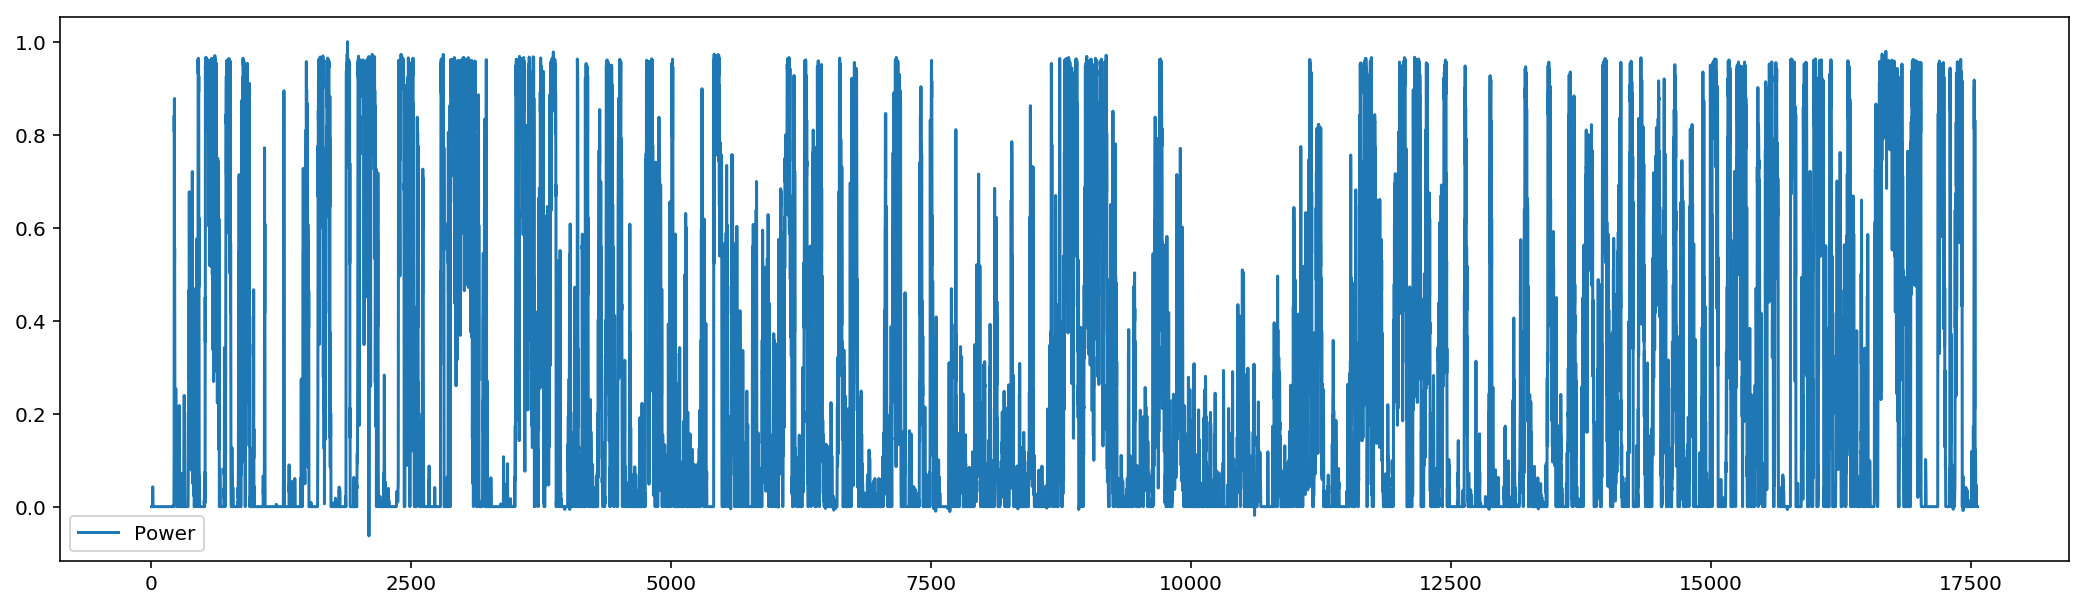

In [7]:
_, ax = plt.subplots(figsize=(18,5))
ax.plot(data_power_normalize[:], label="Power")
ax.legend()

# _, bx = plt.subplots(figsize=(18,5))
# bx.plot(data_wind_normalize, label="Wind")
# bx.legend()

# _, cx = plt.subplots(figsize=(18,5))
# cx.plot(data_switch_flatten, label="Switch")
# cx.legend()

### Prepare batches

In [8]:
window = 16
batch_size = 125

feed_data = np.column_stack((data_power_normalize, data_wind_normalize, data_direc_normalize))
print(feed_data.shape[:])
features = feed_data.shape[1]
print(features)

(17568, 3)
3


In [9]:
def load_data(data, window, features):
    seq_len = window + 1
    breakdown = []
    for index in range(len(data) - seq_len):
        breakdown.append(np.array(data[index: index+seq_len]))
    
    breakdown = np.array(breakdown)
    print("All data", np.shape(breakdown))
    barrier = round(0.9 * breakdown.shape[0])
    train = np.array(breakdown[:int(barrier), :])
    print("Train", np.shape(train))

    x_train = np.array(train[:, :-1])
    print("x_train", np.shape(x_train))
    y_train = np.array(train[:, 1:])
    print("y_train", np.shape(y_train))
    
#     print(np.array(list(
#         zip(x_train[200:210, -1, 0], y_train[200:210, -2, 0])
#     )))
    
    x_test = np.array(breakdown[int(barrier):, :-1])
    print("x_test", np.shape(x_test))
    y_test = np.array(breakdown[int(barrier):, 1:])
    print("y_test", np.shape(y_test))

    return (x_train, y_train, x_test, y_test)
 

# Prepare data
x_train, y_train, x_test, y_test = load_data(feed_data, window, features)

# print("x_train", x_train.shape)
# print("y_train", y_train.shape)
# print("x_test", x_test.shape)
# print("y_test", y_test.shape)


All data (17551, 17, 3)
Train (15796, 17, 3)
x_train (15796, 16, 3)
y_train (15796, 16, 3)
x_test (1755, 16, 3)
y_test (1755, 16, 3)


In [10]:
def combined_shuffle(X, Y):
    combined = np.array(list(zip(X, Y)))
    np.random.shuffle(combined)
    return combined[:,0], combined[:,1]

x_train_shuffled, y_train_shuffled = combined_shuffle(x_train, y_train)
print(x_train_shuffled.shape[:])

(15796, 16, 3)


In [11]:
def split_batches(data):
    length = data.shape[0]
    n_batches = length // batch_size
    remain = length % batch_size
    
    truncated = data[:n_batches*batch_size]
    batches = np.array(np.split(
        truncated.reshape(batch_size, -1, features), n_batches, 1))
    print("From ", truncated.shape, " to ", batches.shape[:], "Discard remain: ", remain)
    return batches

def zip_batches(X, Y):
    return np.array(list(zip(X, Y)))

x_train_batches = split_batches(x_train_shuffled)
y_train_batches = split_batches(y_train_shuffled)

train_batches = zip_batches(x_train_batches, y_train_batches)
print(train_batches.shape[:])



From  (15750, 16, 3)  to  (126, 125, 16, 3) Discard remain:  46
From  (15750, 16, 3)  to  (126, 125, 16, 3) Discard remain:  46
(126, 2, 125, 16, 3)


## Building model

In [12]:
learning_rate = 0.001
lstm_size = 256
rnn_layers = 3

In [33]:
# xxx = [[1,1,1],[2,2,2],[3,3,3],
#        [4,4,4],[5,5,5],[6,6,6],
#        [7,7,7],[8,8,8],[9,9,9]]
# yyy = [9,8,7,6,5,4,3,2,1]

# Build
from tensorflow.contrib import seq2seq

train_graph = tf.Graph()
with train_graph.as_default():
    input_tensor = tf.placeholder(tf.float32, [None, window, features], name='inputs')
    target_tensor = tf.placeholder(tf.float32, [None, window, features], name='targets')

    # LSTM RNN
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    rnn_cell = tf.contrib.rnn.MultiRNNCell([lstm] * rnn_layers)
    initial_state = tf.identity(rnn_cell.zero_state(batch_size, tf.float32), name='initial_state')

    rnn_outputs, final_state = tf.nn.dynamic_rnn(rnn_cell, inputs=input_tensor, dtype=tf.float32)
    nn_outputs = tf.contrib.layers.fully_connected(rnn_outputs, features, activation_fn=None)
    prediction = tf.nn.relu(nn_outputs, name='prediction')
    
    total_loss = tf.square(prediction - target_tensor)
    total_cost = tf.reduce_mean(total_loss)
    power_loss = tf.square(prediction[:,-1,0] - target_tensor[:,-1,0])
    power_cost = tf.reduce_mean(power_loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(power_cost)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


## Executing the model & RMS/RMSE results

In [24]:
epochs = 1
show_every_n_batches = round(batch_size/5)

In [38]:
# Train

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(epochs):
        for bchs_i, (x, y) in enumerate(train_batches):
            feed = {input_tensor: x, target_tensor: y}
            total_c, power_c, _ = sess.run([total_cost, power_cost, optimizer], feed)
            
            if (epoch_i * batch_size + bchs_i) % show_every_n_batches == 0:
                print('Epoch {:>3} '.format(epoch_i),
                      'Batch {:>4}/{}   '.format(bchs_i,batch_size),
                      'total_cost = {:.3f}   '.format(total_c),
                      'power_cost = {:.3f}'.format(power_c))

    saver = tf.train.Saver()
    save_dir = 'Checkpoints/'
    saver.save(sess, save_dir+"ckpt")
    print('Model Trained and Saved')


Epoch   0  Batch    0/125    total_cost = 0.136    power_cost = 0.149
Epoch   0  Batch   25/125    total_cost = 0.105    power_cost = 0.036
Epoch   0  Batch   50/125    total_cost = 0.099    power_cost = 0.028
Epoch   0  Batch   75/125    total_cost = 0.098    power_cost = 0.026
Epoch   0  Batch  100/125    total_cost = 0.089    power_cost = 0.018
Epoch   0  Batch  125/125    total_cost = 0.084    power_cost = 0.016
Model Trained and Saved


In [39]:
# Test
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
#     for bchs_i, (x, y) in enumerate(test_batches):
#     for bchs_i in range(len(x_test)):
#         x = x_test[bchs_i]
#         y = y_test[bchs_i]
    feed = {
        input_tensor: x_test,
        target_tensor: y_test}
    total_c, power_c = sess.run([total_cost, power_cost], feed)
    print('total_cost = {:.3f}   '.format(total_c),
          'power_cost = {:.3f}'.format(power_c))


total_cost = 0.127    power_cost = 0.022


# Prediction Result

In [40]:
print(x_test.shape[:])
print(y_test.shape[:])
print(y_test[:,-1,0].shape[:])
np.array(list(zip(x_test[:10,-1,0],
                  y_test[:10,-2,0])))

(1755, 16, 3)
(1755, 16, 3)
(1755,)


array([[ 0.26935179,  0.26935179],
       [ 0.45456261,  0.45456261],
       [ 0.62511012,  0.62511012],
       [ 0.85966016,  0.85966016],
       [ 0.60490876,  0.60490876],
       [ 0.49521713,  0.49521713],
       [ 0.84417874,  0.84417874],
       [ 0.31157961,  0.31157961],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [45]:
 with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
    feed = {input_tensor: x_test}
    pred = sess.run([prediction], feed_dict=feed)
    pred_val = np.array(pred)[0]
    
    print(pred_val.shape)

(1755, 16, 3)


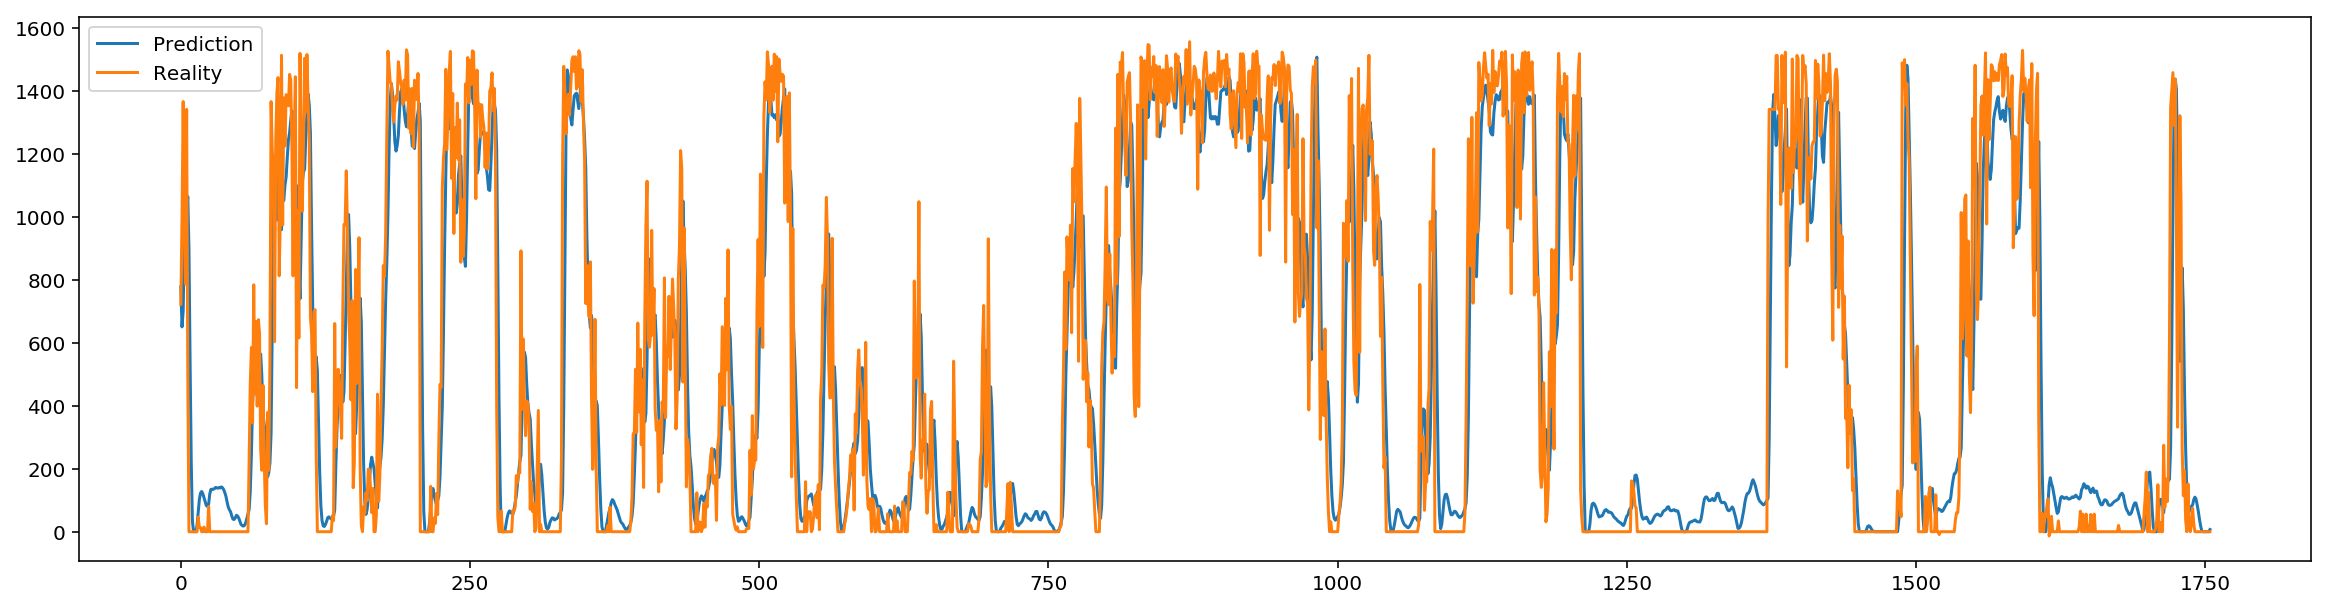

In [46]:
pred_val_power = pred_val[:,-1,0] * power_max_val
test_val_power = y_test[:,-1,0] * power_max_val

_, ax = plt.subplots(figsize=(20,5))
ax.plot(pred_val_power, label="Prediction")
ax.plot(test_val_power, label="Reality")
ax.legend()

## Add cutoff threshold

[False False False ...,  True  True  True]
RMSE:  235.07549486
Cutoff RMSE:  234.992475385


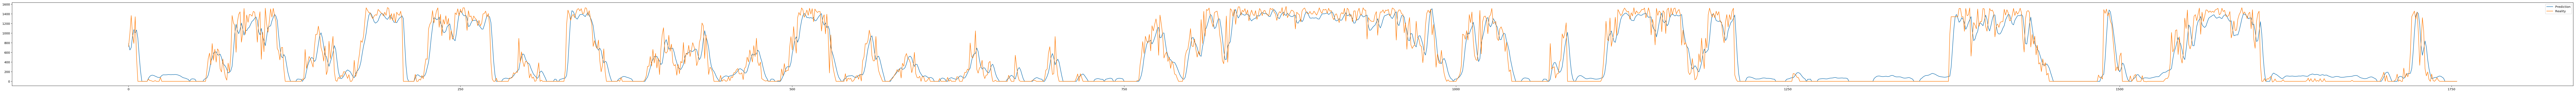

In [47]:
pred_val_power_cutoff = np.array(pred_val_power)

low_values_indices = pred_val_power_cutoff < 40  # Where values are low
print(low_values_indices)
pred_val_power_cutoff[low_values_indices] = 0  # All low values set to 0

_, ax = plt.subplots(figsize=(150,5))
ax.plot(pred_val_power_cutoff, label="Prediction")
ax.plot(test_val_power, label="Reality")
ax.legend()


# import math

from sklearn.metrics import mean_squared_error

def rmse(predictions, targets):
    assert(len(predictions) == len(targets))
    return np.sqrt(((predictions - targets) ** 2).mean())

print("RMSE: ", rmse(test_val_power, pred_val_power))
print("Cutoff RMSE: ", rmse(test_val_power, pred_val_power_cutoff))

## Continuous prediction

(1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16, 3)
(1, 1, 16

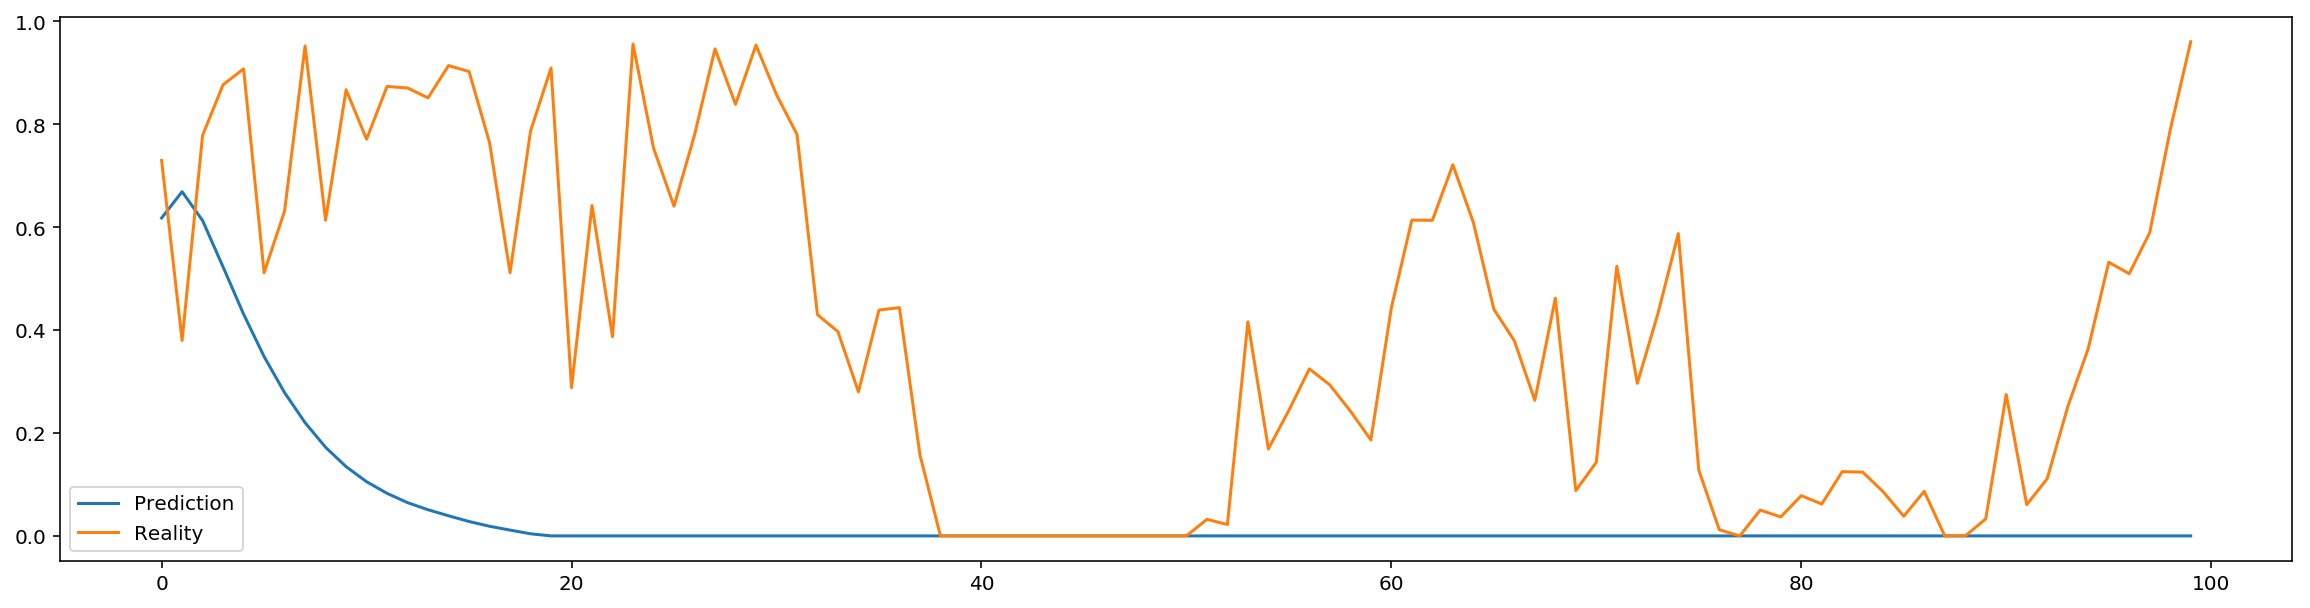

In [48]:
predict_point = 80
predict_length = 100
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
    
    init_x = np.array([x_test[predict_point]])
    print(init_x.shape[:])
    result = list(init_x)
    for i in range(predict_length):
        feed = {input_tensor: init_x}
        pred = sess.run([prediction], feed_dict=feed)
        init_x[0,:-1] = init_x[0,1:]
        print(np.array(pred).shape)
        init_x[0,-1,:] = np.array(pred)[0,0,-1,:]
        result.append(pred[0][0])
    print(np.array(result).shape[:])
    
    power_predict_5h_at_500 = np.array(result)[:,-1,0]
    
_, ax = plt.subplots(figsize=(20,5))
ax.plot(power_predict_5h_at_500[1:], label="Prediction")
ax.plot(y_test[predict_point:predict_point+predict_length,-1,0], label="Reality")
ax.legend()